In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from commons.utils import save, load
from library import *
from process_library_terms import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
#positions, vs, deltat, dims = load('Matt/sim_n64_v03.npy', 4)
#positions, vs, deltat, dims = load('Matt/sim_n1024.npy', 4)
#positions, vs, deltat, dims = load('Matt/sim_n1024_default_v2.npy', 4)
positions, vs, deltat, dims = load('Matt/sim_n10000_faster.npy', 4)

#Lsf = 100 # length scaling factor - to nondimensionalize rho
#Tsf = 0.01 # time scaling factor - to keep v~O(1)
#positions *= Lsf
#vs *= (Lsf*Tsf)
#deltat /= Tsf
#dims[:-1] *= Lsf

print(positions.shape, vs.shape, deltat, dims)

Np, nt = positions.shape[0], positions.shape[2]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

(10000, 2, 512) (10000, 2, 512) 0.0015309310892394864 [  1 512]
[  1   1 512]


In [4]:
# import matplotlib.pyplot as plt
# from matplotlib import animation
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

# vid_file = 'Matt/sim_n10000_faster.mp4'

# fig, ax = plt.subplots(figsize=(6, 6))
# qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

# def animate(i):
#     if i % 10 == 0:
#         print(i)
#     qv.set_offsets(positions[:, :, i])
#     norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
#     qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
#     return qv,

# anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
# FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
# anim.save(vid_file, writer=FFwriter, dpi=100)

In [5]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable(string='v', rank=1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 0.02 #0.2
#corr_T = 0.01 #0.1
kernel_sigma = 0.02 # 0.05
cg_res = 256
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, rho_scale=Np,
                irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
v_est = np.mean(np.abs(vs))*2**0.5
print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 0.1 # 0.3
dom_time = 40
#srd.make_domains(ndomains=10, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
srd.make_weights(m=8, qmax=1)
srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
#srd.set_LT_scale(L=corr_L, T=corr_T) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

save('Q_gauss1024.npy', srd)

0.8220362128487468
 

         111659178 function calls (106344340 primitive calls) in 351.441 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4260  241.674    0.057  241.687    0.057 coarse_grain_utils.py:267(poly_coarse_grain_time_slices)
     4260   29.469    0.007  284.719    0.067 process_library_terms.py:92(eval_prime)
      351   11.433    0.033   11.446    0.033 {built-in method time.sleep}
   636480   11.109    0.000   11.487    0.000 polynomial.py:672(polyval)
   636480    4.620    0.000    6.630    0.000 _function_base_impl.py:5078(trapezoid)
   212160    3.601    0.000  292.009    0.001 process_library_terms.py:400(eval_term)
   467520    2.922    0.000    8.050    0.000 arrayprint.py:966(fillFormat)
   636480    2.625    0.000    3.742    0.000 function_base.py:25(linspace)
  1604419    2.565    0.000    2.565    0.000 {method 'reduce' of 'numpy.ufunc' objects}
2362560/467520    2.387    0.000    5.669    0.000 arrayprint.py:81

Text(0, 0.5, 'rho[v_x]')

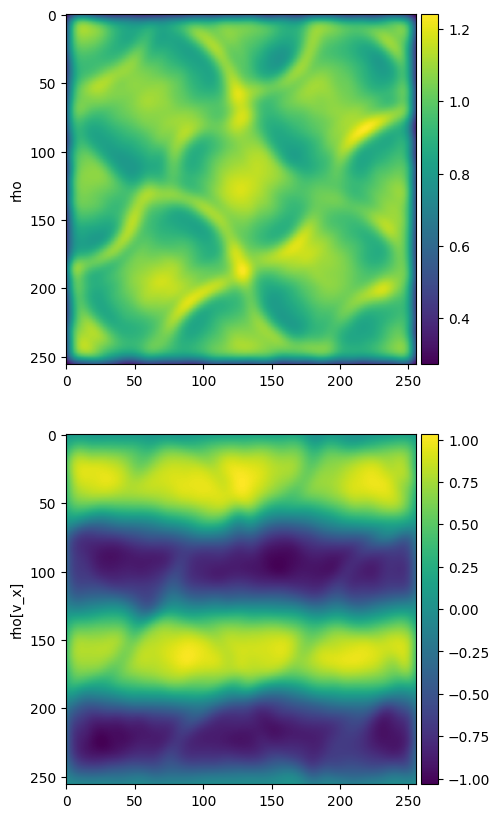

In [6]:
from scipy.stats._stats import gaussian_kernel_estimate
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

def coarse_grain_slice(t, sigma, field='rho', component=None):
    pt_pos = positions[:, :, t]
    weights = np.ones(pt_pos.shape[0], dtype=np.float64)
    if field == 'v':
        weights *= vs[:, component, t]
    xx, yy = np.meshgrid(np.linspace(0, 1, cg_res), np.linspace(0, 1, cg_res))
    xi = np.vstack([xx.ravel(), yy.ravel()]).T

    sigma_sq = sigma ** 2
    # Check scipy version. If it's lower than 1.10, use inverse_covariance, otherwise use Cholesky
    if int(scipy.__version__.split(".")[0]) <= 1 and int(scipy.__version__.split(".")[1]) < 10:
        inv_cov = np.eye(2) / sigma_sq
    else:
        inv_cov = np.eye(2) * sigma_sq
        inv_cov = np.linalg.cholesky(inv_cov[::-1, ::-1]).T[::-1, ::-1]
    density = gaussian_kernel_estimate['double'](pt_pos, weights[:, None], xi, inv_cov,
                                                 np.float64)
    output = np.reshape(density[:, 0], xx.shape) / 1e4
    return output

t = 100
sigma = kernel_sigma
rho_cg = coarse_grain_slice(t, sigma, field='rho')
vx_cg = coarse_grain_slice(t, sigma, field='v', component=0)
vy_cg = coarse_grain_slice(t, sigma, field='v', component=1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
im1 = ax1.imshow(rho_cg)
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)

im2 = ax2.imshow(vx_cg)
#colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cb2 = plt.colorbar(im2, cax=cax2)

ax1.set_ylabel('rho')
ax2.set_ylabel('rho[v_x]')

In [7]:
from commons.identify_models import *
import copy

#srd = load('Q_gauss1024.npy', 1)
libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    #print(np.linalg.norm(libs[irrep].Q, axis=0))
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=0.8)
    init = Initializer(method='combinatorial', start_k=3)
    #init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=15)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    #res = Residual(residual_type='dominant_balance')
    res = Residual(residual_type='matrix_relative')
    
    iterator = ModelIterator(max_k=15, backward_forward=True, max_passes=3)
    #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.3, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
reg_opts_list, threshold=2e-2, experimental=True, report_accuracy=True)
#reg_opts_list, threshold=5e-2, experimental=True)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.01 s]
Identified model: 1 · ∂t ρ + ∂α ρ[v_α] = 0 (order 3, train res 1.57e-06, test res 2.07e-06)
(Accuracy = 1.71e-06)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0

[6.464e-01 1.571e-06 1.555e-06 1.548e-06 1.540e-06 1.532e-06 1.532e-06
 1.532e-06]


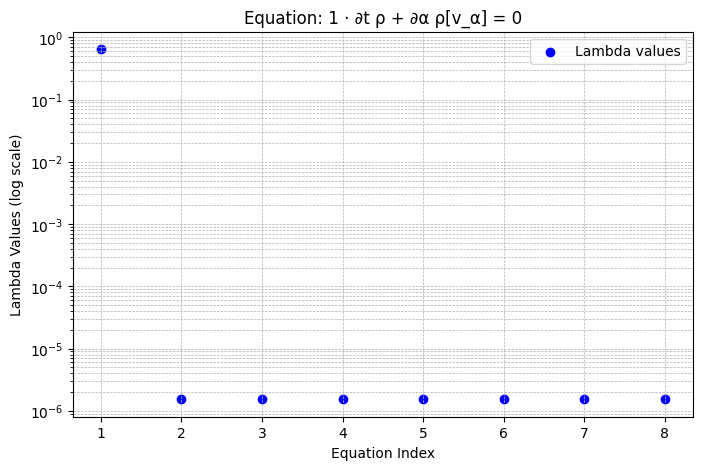

[0.177 0.02  0.02  0.014 0.014 0.013 0.013 0.013 0.013 0.013 0.013 0.013
 0.012 0.012 0.012]


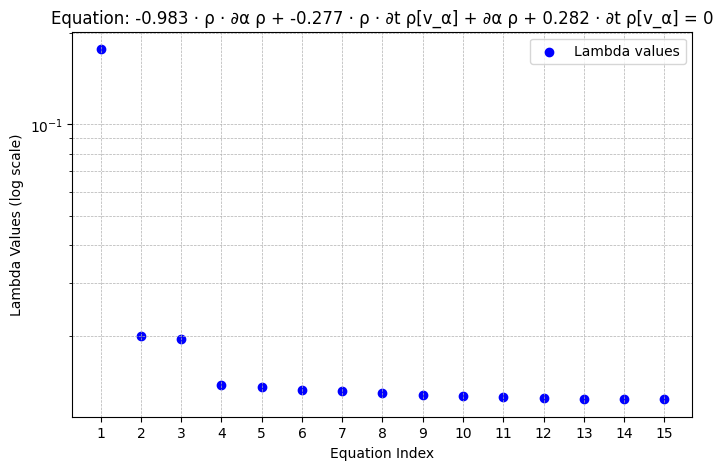

[0.217 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017]


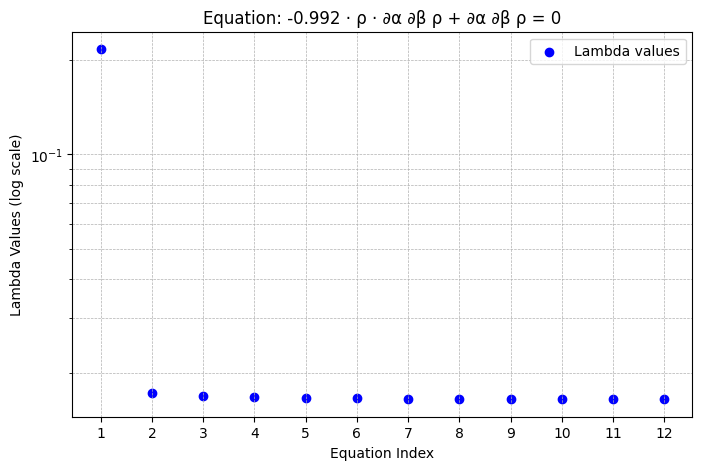

[0.125 0.011 0.01  0.007 0.007 0.006 0.006 0.006 0.005 0.005 0.005 0.005
 0.005 0.005 0.005]


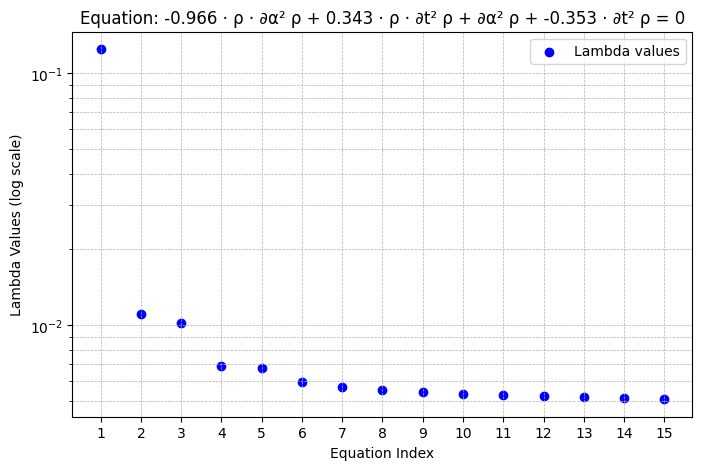

[0.16  0.016 0.012 0.011 0.011 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01 ]


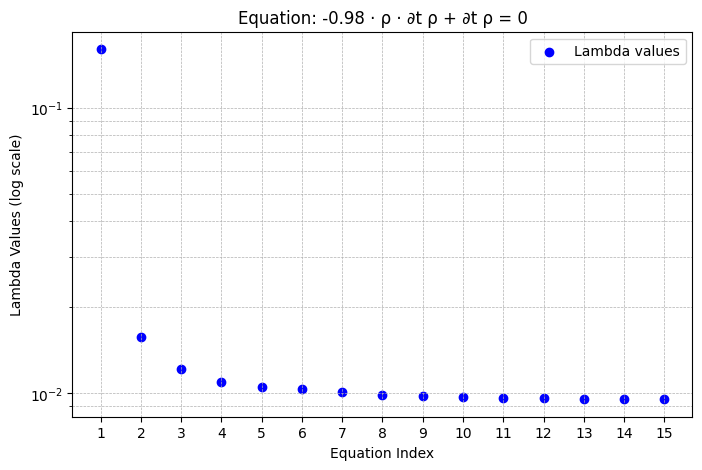

[0.176 0.023 0.019 0.012 0.012 0.012 0.011 0.01  0.01  0.01  0.009 0.009
 0.009 0.009 0.009]


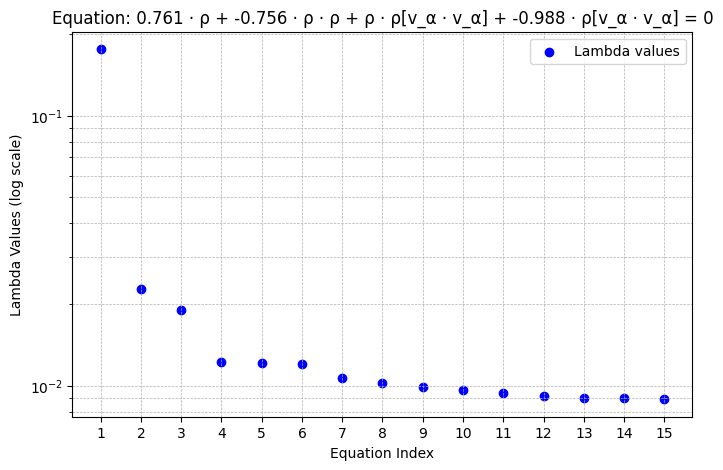

[0.102 0.012 0.009 0.008 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006
 0.006 0.006 0.006]


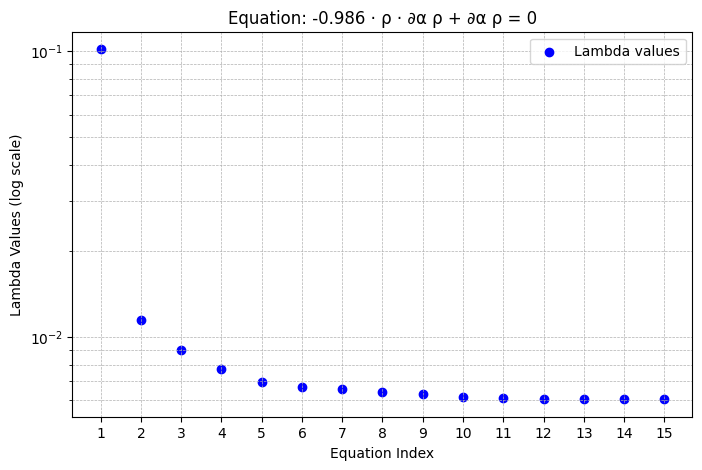

[0.204 0.022 0.019 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.009
 0.009 0.009 0.009]


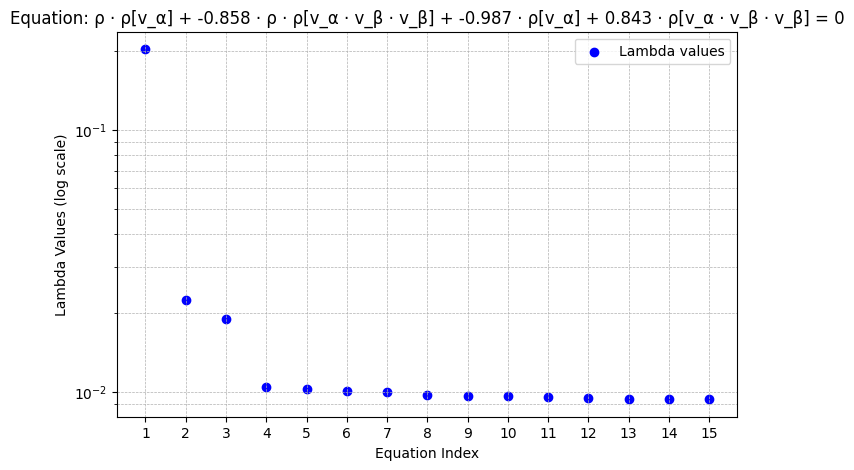

[5.408e-01 8.122e-02 3.953e-16 7.953e-16 3.105e-16 4.427e-16 6.750e-16
 1.049e-15 3.275e-16 3.169e-16 2.931e-16 2.901e-16 3.829e-16 3.589e-16
 3.843e-16]


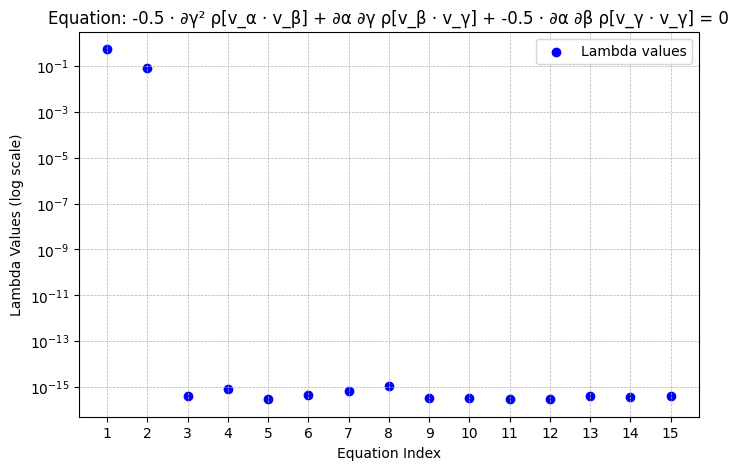

In [8]:
import numpy as np
import matplotlib.pyplot as plt
for i, res in enumerate(reg_results):
    all_lambdas = res.all_lambdas
    print(all_lambdas)
    all_xis = res.all_xis
    xi_values = res.xi
    sublibrary_terms = res.sublibrary
    equations = []
    #equation_terms = [f"{xi:.1e} {term}" for xi, term in zip(xi_values, sublibrary_terms) if abs(xi) > 1e-15]
    #equation_string = " + ".join(equation_terms)
    equation_string = str(eqs[i].pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))

    
    plt.figure(figsize=(8, 5))
    plt.scatter(range(1, len(all_lambdas) + 1), all_lambdas, color='b', label="Lambda values")
    
    # Set log scale for y-axis
    plt.yscale("log")
    
    plt.xlabel("Equation Index")
    plt.ylabel("Lambda Values (log scale)")
    plt.title(f"Equation: {equation_string}")  # Use the computed equation as the title
    plt.xticks(range(1, len(all_lambdas) + 1))  # Ensure x-axis ticks match the number of equations
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    plt.show()

In [9]:
from commons.identify_models import *
import copy

#srd = load('Q_gauss1024.npy', 1)
libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    #print(np.linalg.norm(libs[irrep].Q, axis=0))
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=0.8)
    init = Initializer(method='combinatorial', start_k=3)
    #init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=15)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    #res = Residual(residual_type='dominant_balance')
    res = Residual(residual_type='accuracy')
    
    iterator = ModelIterator(max_k=15, backward_forward=True, max_passes=3)
    #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
#reg_opts_list, threshold=2e-2, experimental=True)
reg_opts_list, threshold=5e-2, experimental=True)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.01 s]
Identified model: 1 · ∂t ρ + ∂α ρ[v_α] = 0 (order 3, train res 1.55e-06, test res 2.04e-06)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 4 ---
-

In [10]:
print(srd.scale_dict)
for irrep in srd.irreps:
    # don't forget preprocessing
    Q = srd.libs[irrep].Q/srd.libs[irrep].col_weights # reweight columns
    for i in range(Q.shape[0]): # normalize rows
        Q[i, :] /= np.linalg.norm(Q[i, :])
    [U, S, V] = np.linalg.svd(Q)
    print(np.linalg.norm(Q)/max(S))

{'v': {'mean': np.float64(0.682238425643628), 'std': np.float64(0.682238425643628)}, 'rho': {'mean': np.float64(1.0), 'std': np.float64(0.11043206185626579)}}
1.4016333382677941
1.5128860448133739
1.5930821028242959
1.7169137757934647


In [11]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\]')))
print(next(regex_find(lib1.terms, r'ρ · ∂t ρ\[v_α\]')))

0 ρ · ∂α ρ 5.521603092813289 3
1 ρ · ∂α ∂β² ρ 13804.007732033222 5
2 ρ · ∂t ∂α ρ 226.9478847635082 4
3 ρ · ∂t² ∂α ρ 9327.968985251404 5
4 ρ · ρ[v_α] 0.682238425643628 3
5 ρ · ∂α ∂β ρ[v_β] 188.35249005349627 5
6 ρ · ∂β² ρ[v_α] 188.35249005349627 5
7 ρ · ∂t ρ[v_α] 3.0966513520841468 4
8 ρ · ∂t² ρ[v_α] 127.27797749901018 5
9 ρ · ∂β ρ[v_α · v_β] 2.5700261256030887 5
10 ρ · ∂α ρ[v_β · v_β] 2.5700261256030887 5
11 ρ · ρ[v_α · v_β · v_β] 0.3175473767892816 5
12 ∂α ρ 5.521603092813289 2
13 ∂β ρ · ∂α ∂β ρ 1524.4050357282642 5
14 ∂α ρ · ∂β² ρ 1524.4050357282642 5
15 ∂α ρ · ∂t ρ 25.06232284835242 4
16 ∂α ρ · ∂t² ρ 1030.106847972612 5
17 ∂α ρ · ∂β ρ[v_β] 20.80015383236939 5
18 ∂β ρ · ∂β ρ[v_α] 20.80015383236939 5
19 ∂β ρ · ∂α ρ[v_β] 20.80015383236939 5
20 ∂β ρ · ρ[v_α · v_β] 2.5700261256030883 5
21 ∂α ρ · ρ[v_β · v_β] 2.5700261256030883 5
22 ∂α ∂β ρ · ρ[v_β] 188.3524900534963 5
23 ∂β² ρ · ρ[v_α] 188.3524900534963 5
24 ∂α ∂β² ρ 13804.007732033222 4
25 ∂t ρ · ∂t ∂α ρ 1030.106847972612 5
26 ∂t ρ · ρ[

In [12]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib0.terms, r'∂α² ρ')))
print(next(regex_find(lib0.terms, r'∂t² ρ')))
print(next(regex_find(lib0.terms, r'∂t ∂α ρ\[v_α\]')))
print(next(regex_find(lib0.terms, r'ρ · ∂α² ρ')))

0 ρ 1.0 1
1 ρ · ρ 1.0 2
2 ρ · ∂α² ρ 276.0801546406645 4
3 ρ · ∂t ρ 4.538957695270164 3
4 ρ · ∂t ∂α² ρ 11347.394238175411 5
5 ρ · ∂t² ρ 186.5593797050281 4
6 ρ · ∂t³ ρ 7667.928298206633 5
7 ρ · ∂α ρ[v_α] 3.7670498010699256 4
8 ρ · ∂t ∂α ρ[v_α] 154.83256760420733 5
9 ρ · ρ[v_α · v_α] 0.46544926942469617 4
10 ρ · ∂t ρ[v_α · v_α] 2.1126545432131008 5
11 ∂α ρ · ∂α ρ 30.488100714565284 4
12 ∂α ρ · ∂t ∂α ρ 1253.116142417621 5
13 ∂α ρ · ρ[v_α] 3.7670498010699256 4
14 ∂α ρ · ∂t ρ[v_α] 17.09847968303228 5
15 ∂α² ρ 276.0801546406645 3
16 ∂α² ρ · ∂t ρ 1253.1161424176212 5
17 ∂α² ∂β² ρ 690200.3866016612 5
18 ∂t ρ 4.538957695270164 2
19 ∂t ρ · ∂t ρ 20.602136959452242 4
20 ∂t ρ · ∂t² ρ 846.7851321369658 5
21 ∂t ρ · ∂α ρ[v_α] 17.098479683032284 5
22 ∂t ρ · ρ[v_α · v_α] 2.1126545432131008 5
23 ∂t ∂α ρ · ρ[v_α] 154.83256760420736 5
24 ∂t ∂α² ρ 11347.394238175411 4
25 ∂t² ρ 186.5593797050281 3
26 ∂t² ∂α² ρ 466398.44926257024 5
27 ∂t³ ρ 7667.928298206633 4
28 ∂t⁴ ρ 315165.7369326759 5
29 ρ[v_α] · ρ[v_α] 0

In [13]:
col_norms = np.linalg.norm(lib0.Q/lib0.col_weights, axis=0)
print(len(col_norms), lib0.Q.shape)
for term, norm in zip(lib0.terms, col_norms/max(col_norms)):
    print(term, norm)

41 (240, 41)
ρ 0.1354259993479566
ρ · ρ 0.14193974404824553
ρ · ∂α² ρ 0.041403759298037496
ρ · ∂t ρ 0.07269849863955585
ρ · ∂t ∂α² ρ 0.0484786766040301
ρ · ∂t² ρ 0.14127719339921824
ρ · ∂t³ ρ 0.29649784271491275
ρ · ∂α ρ[v_α] 0.08759516131772335
ρ · ∂t ∂α ρ[v_α] 0.17022636014547127
ρ · ρ[v_α · v_α] 0.29769644049093497
ρ · ∂t ρ[v_α · v_α] 0.43968863078867004
∂α ρ · ∂α ρ 0.039346400735563045
∂α ρ · ∂t ∂α ρ 0.011948124886877284
∂α ρ · ρ[v_α] 0.05825278814213814
∂α ρ · ∂t ρ[v_α] 0.16131572950041914
∂α² ρ 0.036795346994964555
∂α² ρ · ∂t ρ 0.01527452255249277
∂α² ∂β² ρ 0.04815437948714188
∂t ρ 0.07079721771050317
∂t ρ · ∂t ρ 0.07804741603369182
∂t ρ · ∂t² ρ 0.05301498013034486
∂t ρ · ∂α ρ[v_α] 0.09404009661641498
∂t ρ · ρ[v_α · v_α] 0.15484604609315583
∂t ∂α ρ · ρ[v_α] 0.060582883013046665
∂t ∂α² ρ 0.048024382663985635
∂t² ρ 0.12859716194871587
∂t² ∂α² ρ 0.14294836842572153
∂t³ ρ 0.29146708984586195
∂t⁴ ρ 1.0
ρ[v_α] · ρ[v_α] 0.22326413582981916
ρ[v_α] · ∂t ρ[v_α] 0.2333901481884672
∂α ρ[v_α]

In [14]:
lib0 = libs[srd.irreps[0]]
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=3)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=15)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=15, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(libs0.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
#opts['inhomog_col'] = 1 # ρ²
opts['inhomog_col'] = 15 # ∂α² ρ
#opts['inhomog_col'] = 25 # ∂t² ρ

remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
accuracy = compute_accuracy(lib0.Q, reg_result.xi, opts['scaler'])
print(f'(Accuracy = {accuracy:.2e})')

∂α² ρ + 3.955857480312368e-05 · ∂α² ∂β² ρ + -0.2518868722963112 · ∂t² ρ + 0.24415496801678635 · ∂α ∂β ρ[v_α · v_β] = 0 ; residual: 0.023074981164648786
(Accuracy = 2.60e-02)


In [15]:
lib1 = libs[srd.irreps[1]]
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=3)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(lib1.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 41 # dt rho[v_i]
opts['verbose'] = False

remove_terms = [7] # rho * dt rho[v_i]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
accuracy = compute_accuracy(lib1.Q, reg_result.xi, opts['scaler'])
print(f'(Accuracy = {accuracy:.2e})')

ρ · ∂α ρ + 3.8461185297143274e-05 · ρ · ∂α ∂β² ρ + 0.2518581351533778 · ∂t ρ[v_α] + 0.2434375826591054 · ∂β ρ[v_α · v_β] = 0 ; residual: 0.013699965762274233
(Accuracy = 1.32e-02)
